# CSC4210 Computer Vision Final Project

This notebook implements the core computer-vision pipeline for my CSC4210 final project using the SunFounder PiCar-X v2. It demonstrates how to:

1. **Capture frames** from an upgraded IMX708-based camera using Picamera2  
2. **Convert and preprocess** each frame (RGB -> BGR, RGB -> HSV, Gaussian blur)  
3. **Run Canny edge detection** and **Hough line transforms** to extract and visualize lane markings  
4. **Log performance metrics** and save intermediate results for documentation  

Use the cells below to iterate on parameter tuning, verify each processing stage, and build toward autonomous path planning on the PiCar-X.  


*Note:* Use Picamera2 for frame capture because OpenCV’s VideoCapture cannot reliably grab frames from the Pi’s CSI camera under the libcamera/V4L2 stack (per Picamera2 and OpenCV documentation)

Imports:

* Pi Camera v2.x
* OpenCV
* NumPy
* Time
* IPython's Display and Image

In [195]:
# Boilerplate code required to run the examples in this notebook
from picamera2 import Picamera2
import cv2 as cv
import numpy as np
import time
from IPython.display import display, Image

# Initialize Picamera2 with the IMX708's native resolution
picam2 = Picamera2()
preview_config = picam2.create_still_configuration(main={"size": (3280, 2464)}) # TODO: adjust resolution for performance?
picam2.configure(preview_config)

# Start the camera and warm-up (e.g. automatic white balance, exposure, etc.)
# The NULL preview is in fact started automatically whenever the camera
# system is started (picam2.start()) if no preview configuration is provided.
picam2.start() # Start the camera
time.sleep(2) # Allow time for the camera to adjust


[1:06:34.580893812] [1846]  INFO Camera camera_manager.cpp:326 libcamera v0.5.0+59-d83ff0a4
[1:06:34.588131066] [2931]  INFO RPI pisp.cpp:720 libpisp version v1.2.1 981977ff21f3 29-04-2025 (14:13:50)
[1:06:34.680094114] [2931]  INFO RPI pisp.cpp:1179 Registered camera /base/axi/pcie@1000120000/rp1/i2c@80000/imx708@1a to CFE device /dev/media2 and ISP device /dev/media0 using PiSP variant BCM2712_C0
[1:06:34.685297923] [1846]  INFO Camera camera.cpp:1205 configuring streams: (0) 3280x2464-BGR888 (1) 4608x2592-BGGR_PISP_COMP1
[1:06:34.685399515] [2931]  INFO RPI pisp.cpp:1483 Sensor: /base/axi/pcie@1000120000/rp1/i2c@80000/imx708@1a - Selected sensor format: 4608x2592-SBGGR10_1X10 - Selected CFE format: 4608x2592-PC1B


In [196]:
picam2.set_controls({"AfMode": 2})
time.sleep(0.1)

picam2.set_controls({
    "AwbMode":          0,      # auto white balance
})
time.sleep(2)  # let the camera converge

#camera_controls = {
#    "AeEnable":          1,       # 1 = on
#    "AeMode":            0,       # 0 = auto
#    "ExposureTime":      20000,   # 20 ms
#    "AnalogueGainMode":  0,       # 0 = auto gain
#    "AnalogueGain":      1.0,     # no gain
#    "Brightness":        0,       # 0 = no brightness
#    "Contrast":          1.0,     # 0 = no contrast
#    "HdrMode":           1,       # 3 = HDR mode
#}

#  Read back the *actual* settled values from the metadata…
#for key in camera_controls.keys():
#    md = picam2.capture_metadata()
#    if key in md.keys():
#        print(f"{key}: {md[key]}")

#for x in picam2.capture_metadata():
#    print(x)

picam2.set_controls({
    "AwbEnable":          0,       # 1 = on
    "AwbMode":            1,       # Auto
    ##"AeEnable":           0,       # 0 = turn off auto-exposure
    "AeConstraintMode":    1,       # 0 = auto
    "AeExposureMode":       2,       # 0 = auto
    "AnalogueGainMode":   0,       # 1 = manual gain
    "AnalogueGain":       2.0,     # double the signal
    "Brightness":         0.3,       # 0 = no brightness
    "Contrast":           1.5,       # 0 = no contrast
    "HdrMode":           0,       # 3 = HDR mode
    "NoiseReductionMode": 2,       # 0 = off
    "Saturation":         1.0,     # 0 = no saturation
    "Sharpness":          1.0,     # 0 = no sharpness
})
time.sleep(1)

## RGB → BGR Conversion

Picamera2 returns images in **RGB** channel order, but OpenCV’s functions (e.g. `cv.Canny`, `cv.cvtColor`, `cv.imencode`) expect **BGR** channel order by default. Feeding an RGB image directly into OpenCV will swap the red and blue channels, causing an unnatural blue cast.

To correct this, we convert with:

```python
bgr = cv.cvtColor(rgb, cv.COLOR_RGB2BGR)


In [197]:
# Utility: grab a frame and convert to proper BGR for OpenCV
def grab_bgr_frame():
    rgb = picam2.capture_array()              # RGB
    rgb = cv.GaussianBlur(rgb, (5, 5), 0)          # Gaussian blur
    bgr = cv.cvtColor(rgb, cv.COLOR_RGB2BGR)  # → BGR
    return bgr

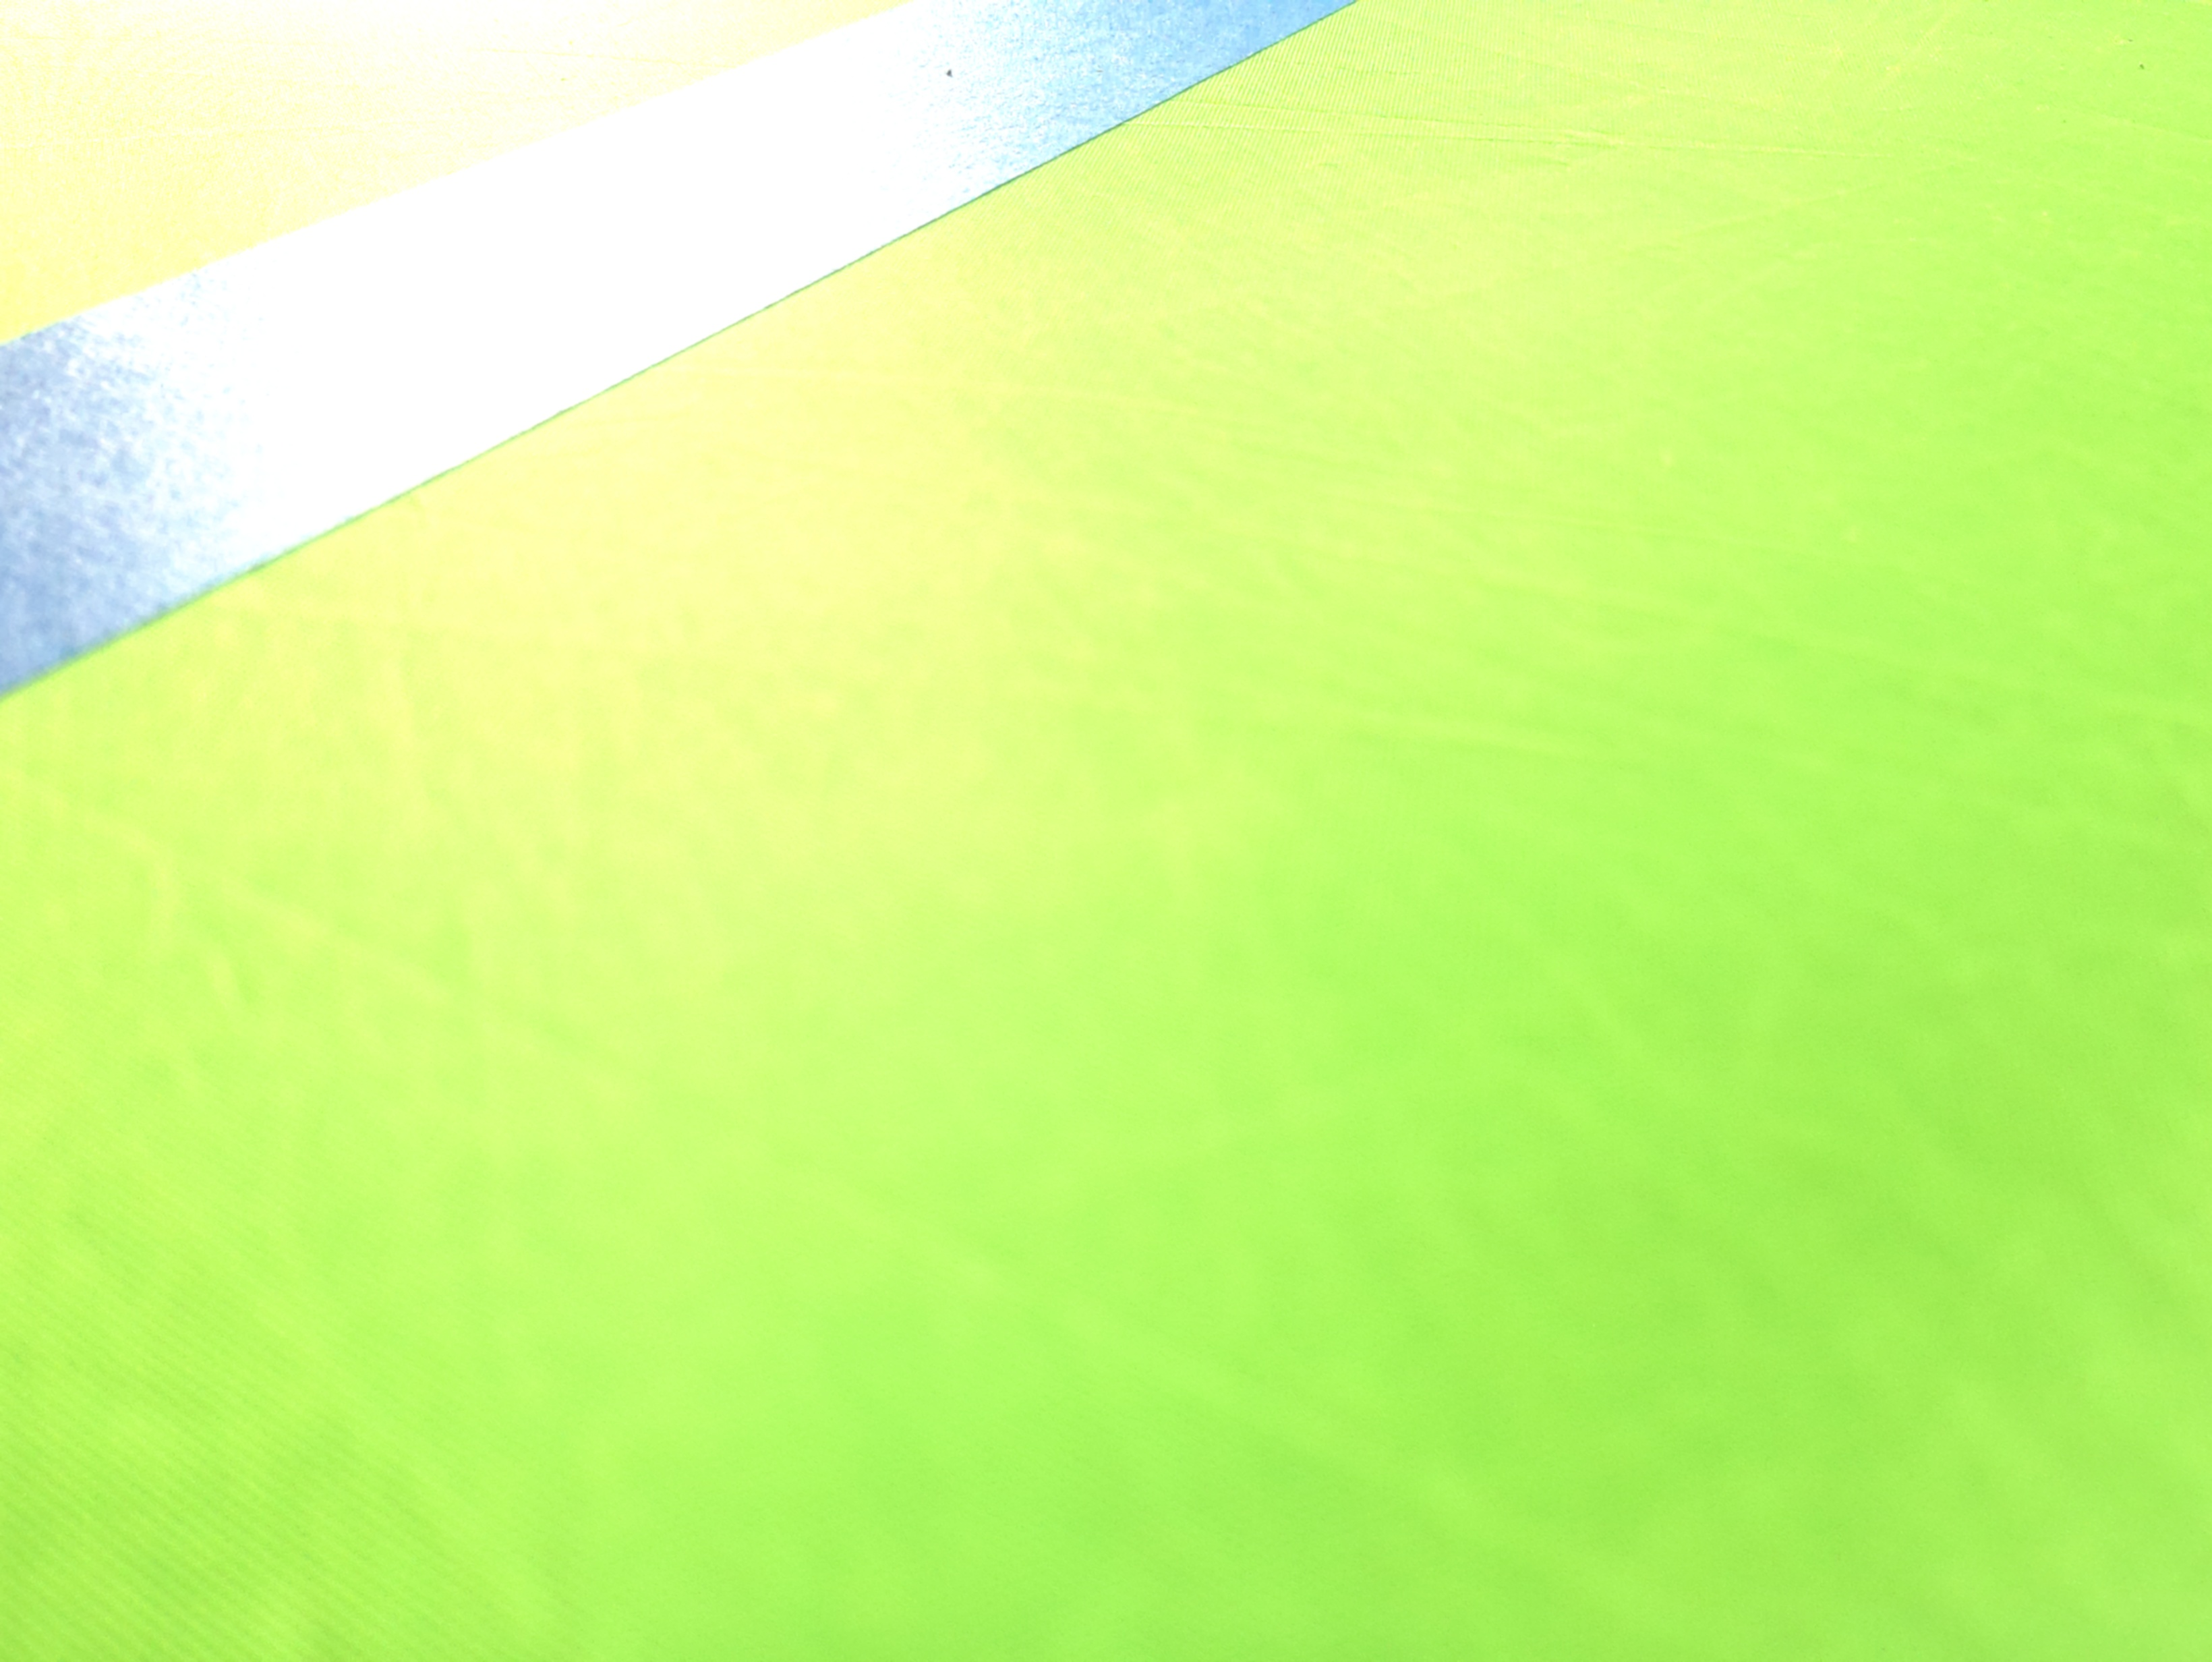

Frame shape: (2464, 3280, 3)


In [198]:
# [2] Experiment: raw frame + inline display
frame = grab_bgr_frame()
frame_small = cv.resize(frame, (640, 480))  # or (1024, 768) for 4:3
_, buf = cv.imencode('.jpg', frame)
display(Image(data=buf.tobytes()))
print("Frame shape:", frame.shape)

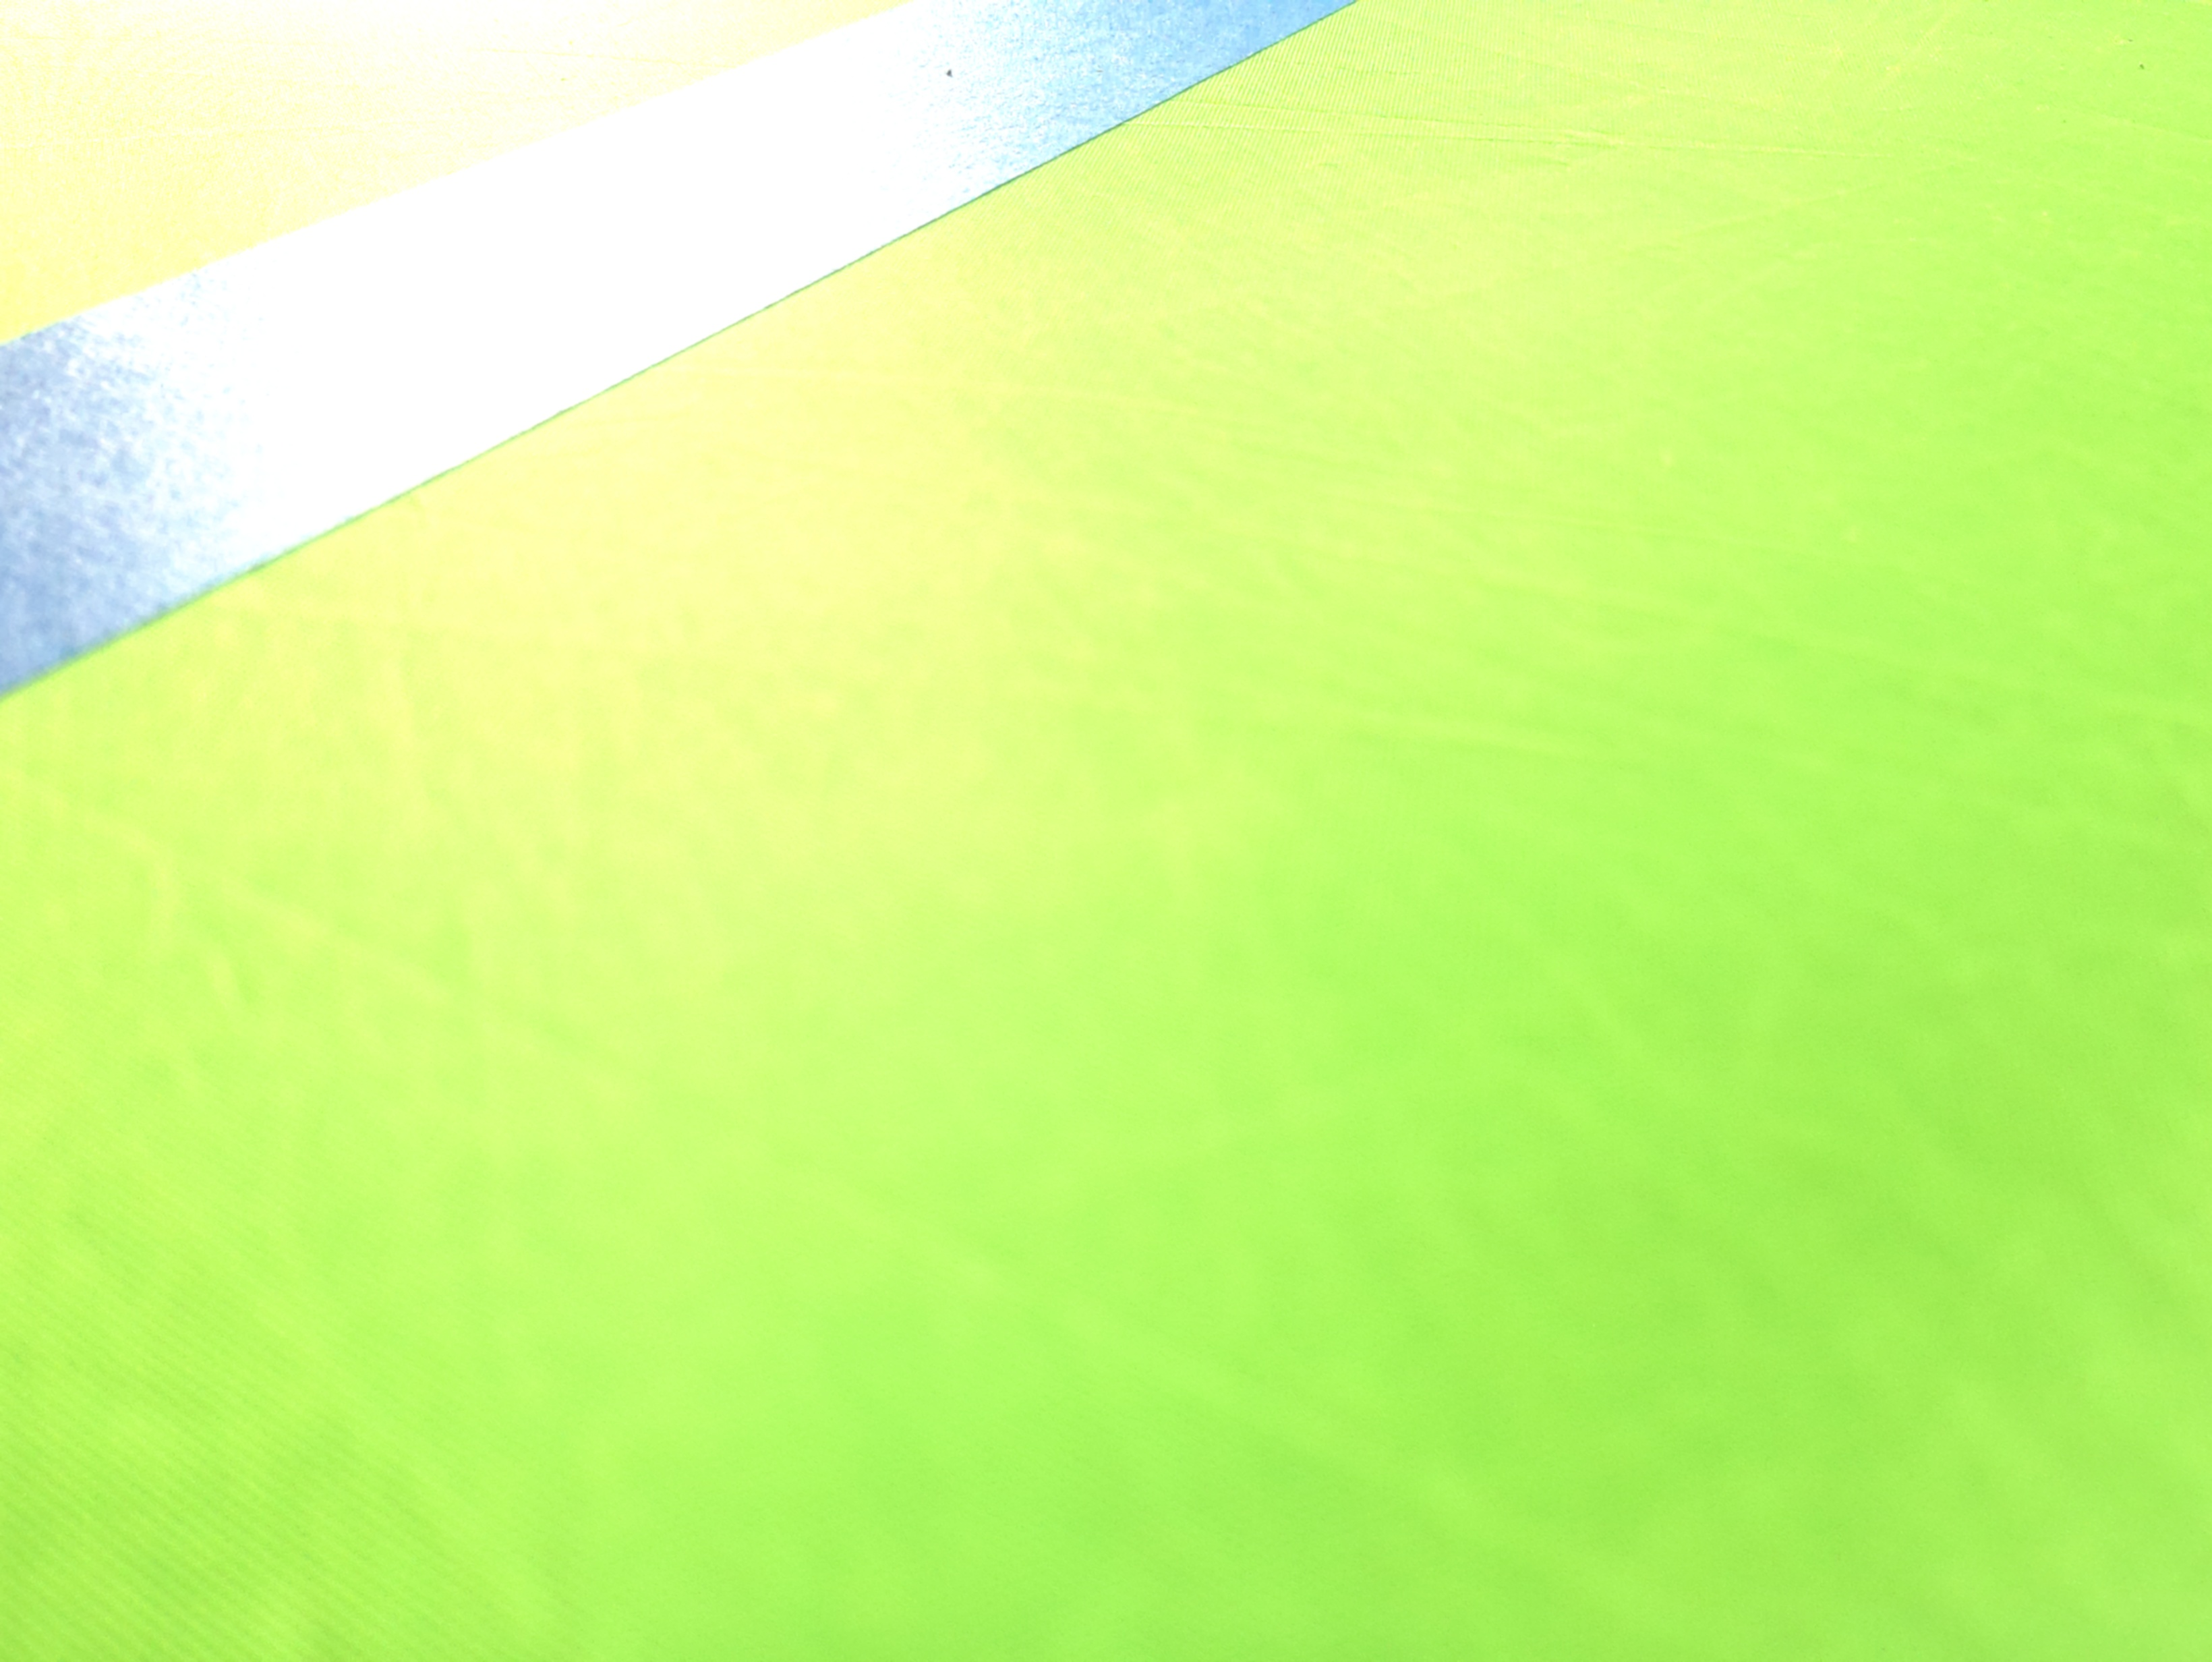

In [199]:
# Focus on the blue painter's tape by converting BGR to HSV and thresholding
# with inRange and bitwise operations
# Ref: docs.opencv.org/4.x/d3/dc1/group__imgproc__color__conversions.html

# Convert from BGR to HSV
hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)

# Define HSV range for blue painter's tape
# Note: the values are in HSV color space (values may
# need to be adjusted based on lighting conditions or
# add an LED light source to the camera)
# in your config up top:
LOWER_BLUE = np.array([95, 120,  50])
UPPER_BLUE = np.array([130, 255, 255])

# Threshold the HSV image to get only blue colors and create a bitmask
# Note: the mask is a binary image where the blue pixels are white (255)
# and the rest are black (0)
mask = cv.inRange(hsv, LOWER_BLUE, UPPER_BLUE)

# Find contours in the mask
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Draw the largest contour (if any) on the original frame
result = frame.copy()
if contours:
    largest_contour = max(contours, key=cv.contourArea)
    cv.drawContours(result, [largest_contour], -1, (255, 0, 255), thickness=cv.FILLED)

# Encode and display the result
_, result_buf = cv.imencode('.jpg', result)
display(Image(data=result_buf.tobytes()))

picam2.close()  # Stop the camera

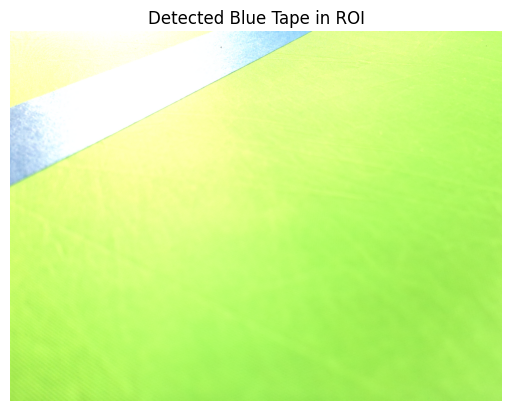

In [200]:
from matplotlib import pyplot as plt

output = frame.copy()

height, width = mask.shape

# Define ROI (bottom quarter, middle half)
#roi = mask[int(height * 0.75):, int(width * 0.25):int(width * 0.75)]

# ROI (bottom quarter, full width)
roi = mask[int(height * 0.5):, :]

# Find contours in ROI
contours, _ = cv.findContours(roi, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Shift contour coordinates to match full frame if needed
offset_x = 0 #int(width * 0.25)
offset_y = int(height * 0.5)

if contours:
    # Draw largest contour on original frame
    largest = max(contours, key=cv.contourArea)
    largest[:, 0, 0] += offset_x
    largest[:, 0, 1] += offset_y
    cv.drawContours(output, [largest], -1, (255, 0, 255), thickness=cv.FILLED)  # Magenta fill

    # draw a vector from the center of the image to the center of the contour
    M = cv.moments(largest)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv.arrowedLine(output, (width // 2, height), (cX, cY), (0, 255, 0), 30)
    
# Show result
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
plt.title("Detected Blue Tape in ROI")
plt.axis("off")
plt.show()

picam2.close()

In [201]:
#import cv2
#import numpy as np
#import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
#from picamera2 import Picamera2

# 1) grab a single frame to play with
#picam2 = Picamera2()
#picam2.configure( picam2.create_preview_configuration(main={"format":"RGB888","size":(640,480)}) )
#picam2.start()
# tiny autofocus & exposure settle
#picam2.set_controls({"AfMode": 2})
#import time; time.sleep(1)
#frame = picam2.capture_array()           # already RGB
#picam2.stop()

# 2) convert once to HSV
#hsv_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
hsv_frame = hsv.copy()

# 3) define the interactive function
def show_hsv_mask(h_low, h_high, s_low, s_high, v_low, v_high):
    low  = np.array([h_low, s_low, v_low])
    high = np.array([h_high, s_high, v_high])
    mask = cv.inRange(hsv_frame, low, high)
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].imshow(cv.cvtColor(hsv_frame, cv.COLOR_HSV2RGB))
    ax[0].set_title("Original RGB")
    ax[0].axis("off")
    
    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title(f"HSV mask\nH[{h_low},{h_high}] S[{s_low},{s_high}] V[{v_low},{v_high}]")
    ax[1].axis("off")
    plt.show()

# 4) wire up the sliders
interact(
    show_hsv_mask,
    h_low = IntSlider(100, min=0,  max=255, description="H low"),
    h_high= IntSlider(180, min=0,  max=255, description="H high"),
    s_low = IntSlider(0, min=0,  max=255, description="S low"),
    s_high= IntSlider(255, min=0,  max=255, description="S high"),
    v_low = IntSlider(0, min=0,  max=255, description="V low"),
    v_high= IntSlider(255, min=0,  max=255, description="V high"),
)


interactive(children=(IntSlider(value=100, description='H low', max=255), IntSlider(value=180, description='H …

<function __main__.show_hsv_mask(h_low, h_high, s_low, s_high, v_low, v_high)>

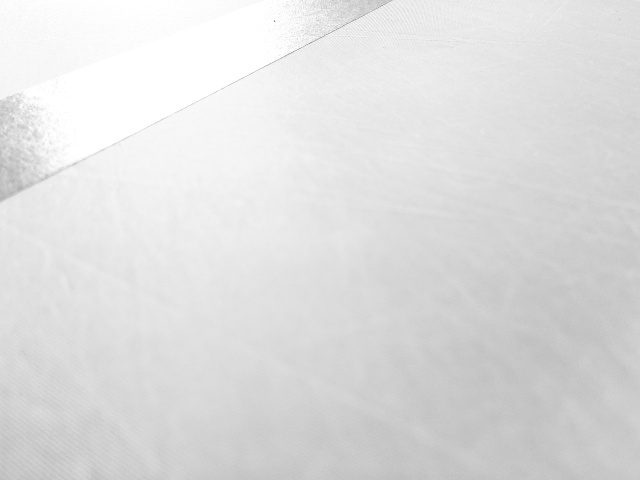

Gray shape: (480, 640)


In [202]:
exit # TODO: deprecate this cell
# %% [3] Experiment: convert to grayscale and display
gray = cv.cvtColor(frame_small, cv.COLOR_BGR2GRAY)
_, buf2 = cv.imencode('.jpg', gray)
display(Image(data=buf2.tobytes()))
print("Gray shape:", gray.shape)

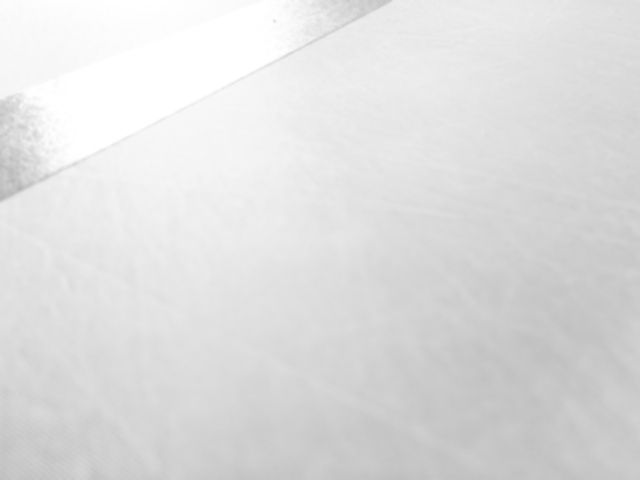

In [203]:
exit # TODO: deprecate this cell
# %% [4] Experiment: apply Gaussian blur
blur = cv.GaussianBlur(gray, (5,5), 0)
_, buf3 = cv.imencode('.jpg', blur)
display(Image(data=buf3.tobytes()))

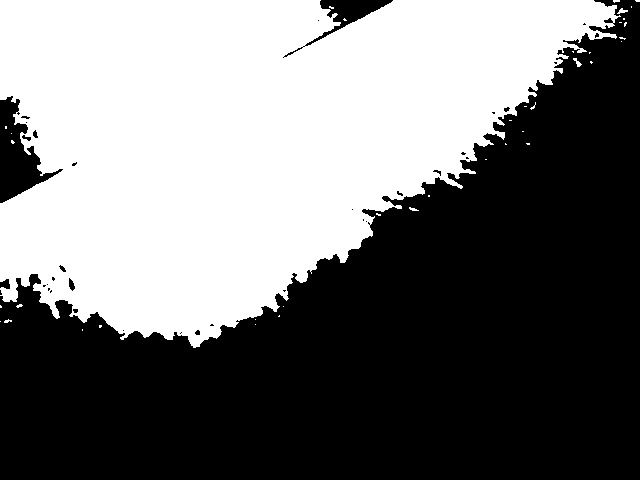

In [204]:
exit # TODO: deprecate this cell
blur = cv.threshold(blur, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
_, buf4 = cv.imencode('.jpg', blur)
display(Image(data=buf4.tobytes()))

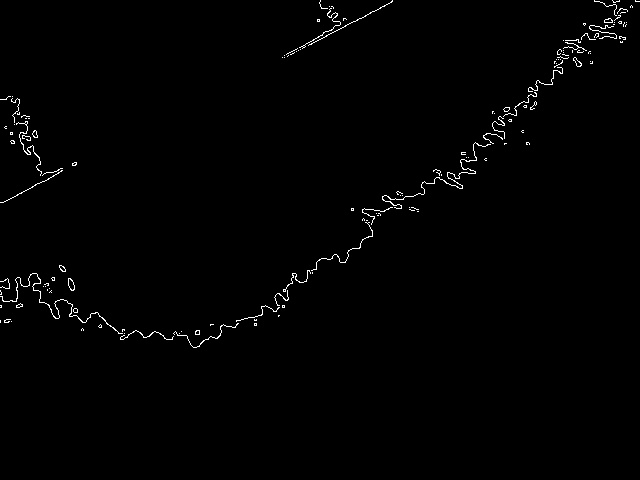

In [205]:
exit # TODO: deprecate this cell
# %% [5] Experiment: Canny edge detection
# thresholds 50 and 150 per OpenCV tutorial
edges = cv.Canny(blur, 192, 150)
_, buf4 = cv.imencode('.jpg', edges)
display(Image(data=buf4.tobytes()))

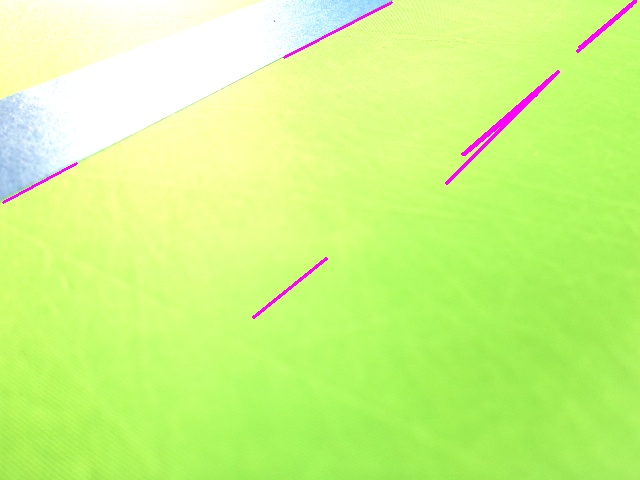

In [206]:
exit # TODO: deprecate this cell
# %% [6] (Stretch) Hough Line Transform
lines = cv.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=10)
vis = frame_small.copy()
if lines is not None:
    for x1,y1,x2,y2 in lines[:,0]:
        cv.line(vis, (x1,y1), (x2,y2), (255,0,255), 2)
_, buf5 = cv.imencode('.jpg', vis)
display(Image(data=buf5.tobytes()))

In [207]:
# close the camera
picam2.close()

# close the OpenCV window
cv.destroyAllWindows()

## References

1. **Sunfounder.** 2023. *PiCar-X User Manual*. Available at: https://docs.sunfounder.com/projects/picar-x/en/latest/

2. **Raspberry Pi Ltd.** 2024. *Picamera2 Library Manual*. Available at: https://datasheets.raspberrypi.com/camera/picamera2-manual.pdf

3. **Greg V. Klimov, Samuel L. Kwok, Cole R. Manning, Mason V. Powell, Sam P. Rowe, and Adam Yang.** 2023. *Remote-Controlled Mixed Reality Driving Experience*. Major Qualifying Project Report, Worcester Polytechnic Institute. Available at: https://digital.wpi.edu/concern/student_works/70795c11v

4. **OpenCV Developers.** 2019. *Changing Colorspaces*. Available at: https://docs.opencv.org/3.4/df/d9d/tutorial_py_colorspaces.html
